In [1]:
import os
import resource
import psutil

# Set memory limit to 16GB (adjust if needed)
memory_limit = 16 * 1024 * 1024 * 1024  # 16GB in bytes
resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))

# Restrict CPU core usage
p = psutil.Process()  # Get the current process
p.cpu_affinity([0, 1, 2])  # Restrict the process to use only CPU cores 0, 1, 2, and 3

In [2]:
import tensorflow as tf
import psutil
from transformers import AutoTokenizer, AutoModelForMaskedLM
import time
import matplotlib.pyplot as plt

# Disable GPU usage
tf.config.set_visible_devices([], 'GPU')

# Optionally disable XLA devices to prevent further warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Print CPU Count
print("CPU Count:", os.cpu_count())

2025-03-17 20:26:33.375050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 20:26:33.375129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 20:26:33.376830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 20:26:33.385521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU Count: 256


In [3]:
model_name = "google-bert/bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Cell 3: Set Pad Token and Model to Evaluation Mode
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

model.eval()  # Set model to evaluation mode

# Define a prompt
prompt = "What is the capital of Denmark?"

# Encode the prompt (tokenize it) with padding
inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

# Add attention mask to the inputs
attention_mask = inputs['attention_mask']

In [5]:
# Cell 4: Measure Latency Over Multiple Iterations
def measure_latency(tokenizer, model, prompt, iterations=25):
    latencies = []
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Encode the prompt with padding
    attention_mask = inputs['attention_mask']  # Get the attention mask
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    start_time = time.time()
    model.generate(
        inputs['input_ids'], 
        attention_mask=attention_mask,  # Pass the attention mask
        max_length=50,
        pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
    )
    end_time = time.time()
    # Calculate latency
    latency = end_time - start_time
    return latency

# Measure and print average latency
latency = measure_latency(tokenizer, model, prompt)
print(f"Average Latency: {latency * 1000:.2f} ms")



Average Latency: 11376.24 ms


Average Throughput: 0.15 samples/second


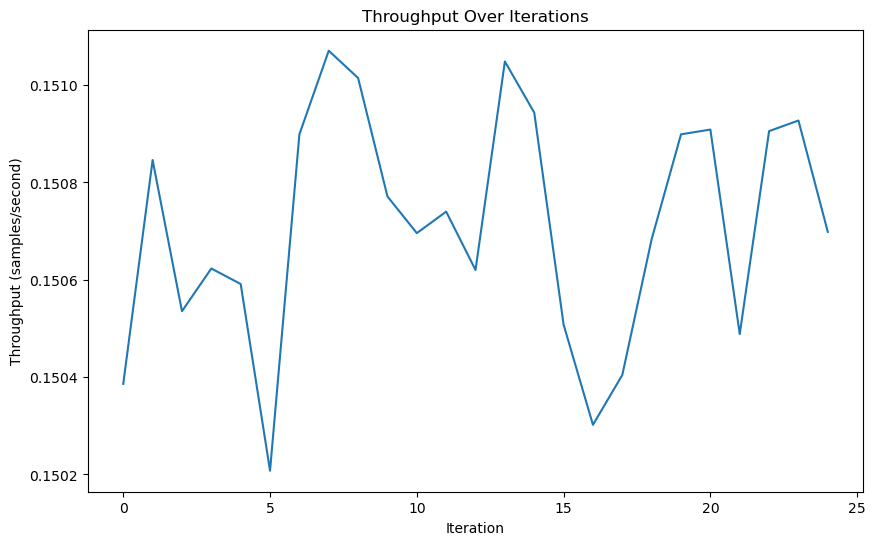

In [6]:
# Cell 5: Measure Throughput Over Multiple Iterations
def measure_throughput(tokenizer, model, prompt, batch_size=8, iterations=25):
    throughputs = []
    inputs = tokenizer([prompt] * batch_size, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    attention_mask = inputs['attention_mask']
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        throughputs.append(throughput)
    
    average_throughput = sum(throughputs) / len(throughputs)
    return throughputs, average_throughput

# Measure and print average throughput
prompt = "Mary had a little lamb"
throughputs, average_throughput = measure_throughput(tokenizer, model, prompt)
print(f"Average Throughput: {average_throughput:.2f} samples/second")

# Plot throughput over iterations
plt.figure(figsize=(10, 6))
plt.plot(throughputs)
plt.title('Throughput Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Throughput (samples/second)')
plt.show()

Average Memory Usage: 47589.37 MB


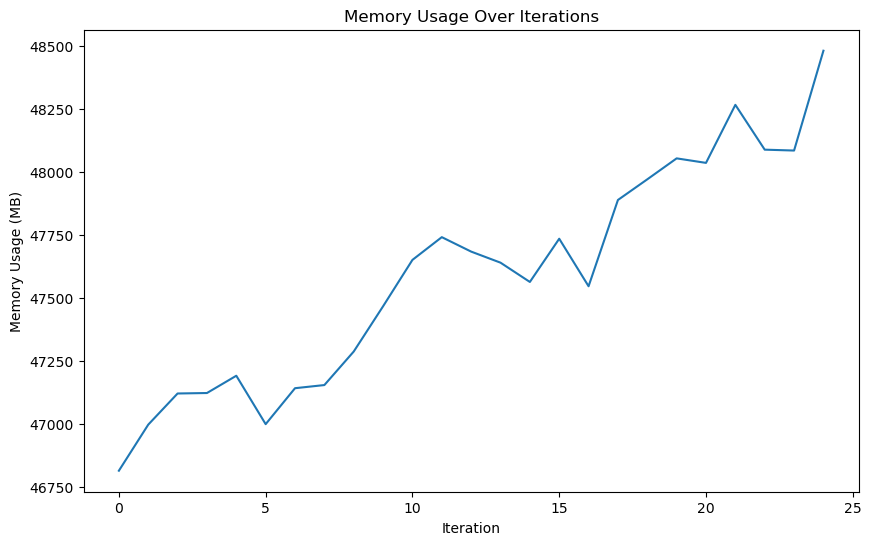

In [7]:
# Cell 6: Track Memory Usage
def get_memory_usage():
    memory = psutil.virtual_memory()
    return memory.used  # Return memory used in bytes

def track_memory_usage(model, inputs, attention_mask, iterations=25):
    memory_usages = []
    for _ in range(iterations):
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=attention_mask,  # Provide attention mask
            max_length=100,  # Maximum number of tokens to generate
            num_return_sequences=1,  # Number of output sequences
            no_repeat_ngram_size=2,  # Prevent repetition
            top_p=0.92,  # Nucleus sampling (controls randomness)
            top_k=50,  # Top-k sampling
            temperature=0.85,  # Lower temperature makes text less random
            do_sample=True,  # Enable sampling mode to use top_p, top_k, and temperature
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        memory_usage = get_memory_usage()
        memory_usages.append(memory_usage)
    
    average_memory_usage = sum(memory_usages) / len(memory_usages)
    return memory_usages, average_memory_usage

# Define inputs and attention mask
prompt = "What is the capital of Denmark and what is the capital of India?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True)
attention_mask = inputs['attention_mask']

# Track memory usage over iterations
memory_usages, average_memory_usage = track_memory_usage(model, inputs, attention_mask)

# Print average memory usage
print(f"Average Memory Usage: {average_memory_usage / (1024 * 1024):.2f} MB")

# Plot memory usage over iterations
plt.figure(figsize=(10, 6))
plt.plot([usage / (1024 * 1024) for usage in memory_usages])  # Convert bytes to MB for plotting
plt.title('Memory Usage Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.show()
